In [1]:
import torch
import yaml
import glob
import numpy as np
import matplotlib.pyplot as plt

from credit.vit2d import ViT2D
from credit.rvt import RViT
from credit.data import ToTensor, NormalizeState, DistributedSequentialDataset
from torchvision import transforms
from credit.metrics import LatWeightedMetrics
from credit.loss import VariableTotalLoss2D
import gc

from collections import defaultdict
from credit.metrics import anomaly_correlation_coefficient as ACC

In [57]:
# orientation is TOA -> surf
# self.allvarsdo = ['U'(0-14),'V' (15-29),'T'(30-44),'Q'(45-59),'SP'(60),'t2m'(61),'V500'(62),'U500'(63),'T500'(64),'Z500'(65),'Q500'(66)]
Dovar = 59

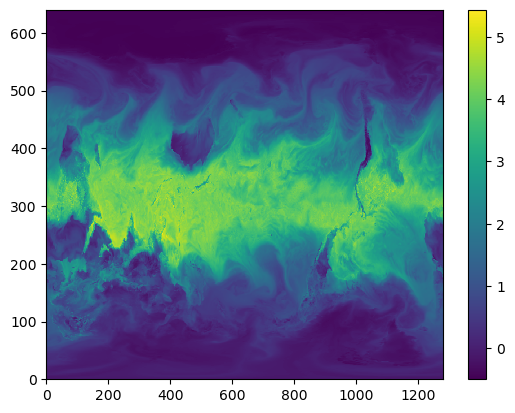

In [54]:
plt.pcolor(y[0, 59, :, :].to("cpu").numpy())
plt.colorbar()
plt.show()

In [2]:
save_loc = "/glade/work/schreck/repos/global/miles-credit/results/rvt_pe"

device = "cuda:0"
config_file = f"{save_loc}/model.yml"

In [3]:
with open(config_file) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [5]:
history_len = 23
forecast_len = 24
time_step = 1

# datasets (zarr reader)
all_ERA_files = sorted(glob.glob(conf["data"]["save_loc"]))

# Specify the years for each set
test_years = [
    str(year) for year in range(2018, 2022)
]  # same as graphcast -- always hold out

# Filter the files for each set (2018-2019)
test_files = [
    file for file in all_ERA_files if any(year in file for year in test_years)
][:2]

transform = transforms.Compose(
    [
        NormalizeState(conf["data"]["mean_path"], conf["data"]["std_path"]),
        ToTensor(history_len=history_len, forecast_len=forecast_len),
    ]
)

test_dataset = DistributedSequentialDataset(
    filenames=test_files,
    history_len=history_len,
    forecast_len=forecast_len,
    skip_periods=time_step,
    transform=transform,
    rank=0,
    world_size=1,
    shuffle=True,
)

# setup the dataloder for this process
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
    drop_last=True,
)

In [10]:
if "use_rotary" in conf["model"] and conf["model"]["use_rotary"]:
    model = RViT.load_model(conf).to(device)
else:
    if "use_rotary" in conf["model"]:
        del conf["model"]["use_rotary"]
        del conf["model"]["use_ds_conv"]
        del conf["model"]["use_glu"]
    model = ViT2D.load_model(conf).to(device)

In [13]:
conf["loss"]["use_latitude_weights"] = True

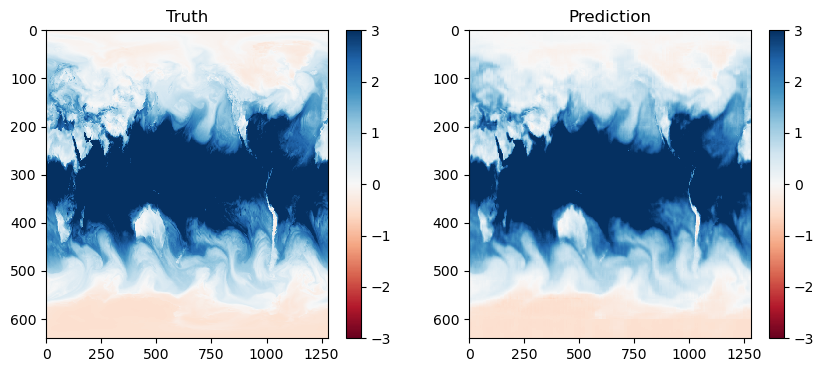

tensor([3203]) tensor([0]) tensor(0.0593, device='cuda:0', dtype=torch.float64) 0.992818295955658


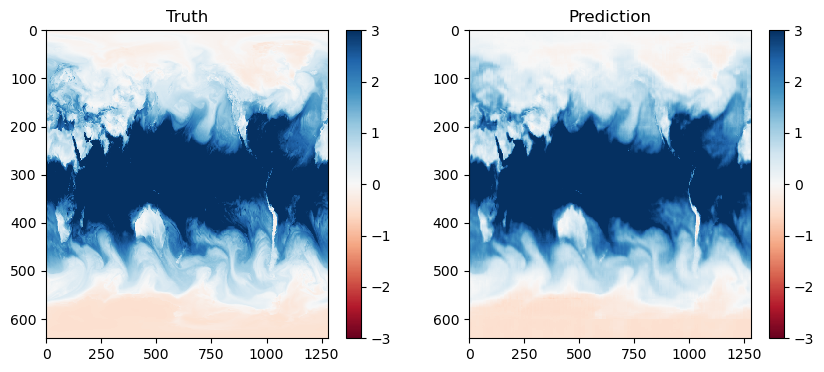

tensor([3203]) tensor([1]) tensor(0.0698, device='cuda:0', dtype=torch.float64) 0.9899746775627136


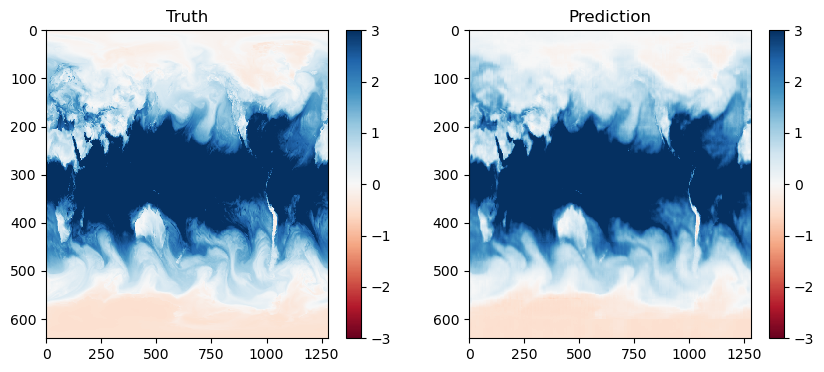

tensor([3203]) tensor([2]) tensor(0.0808, device='cuda:0', dtype=torch.float64) 0.9863500595092773


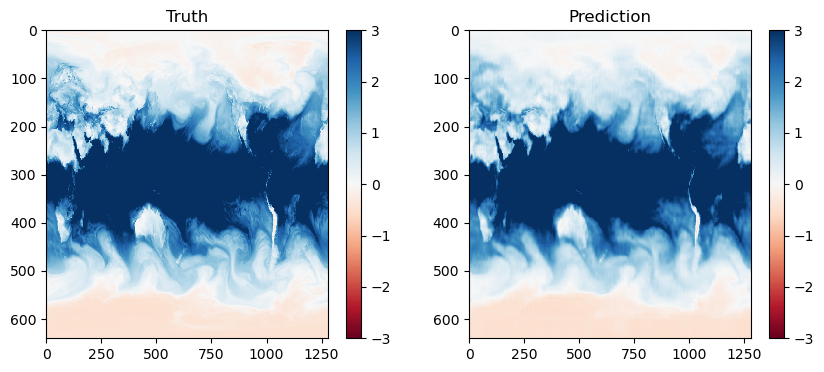

tensor([3203]) tensor([3]) tensor(0.0915, device='cuda:0', dtype=torch.float64) 0.9821580052375793


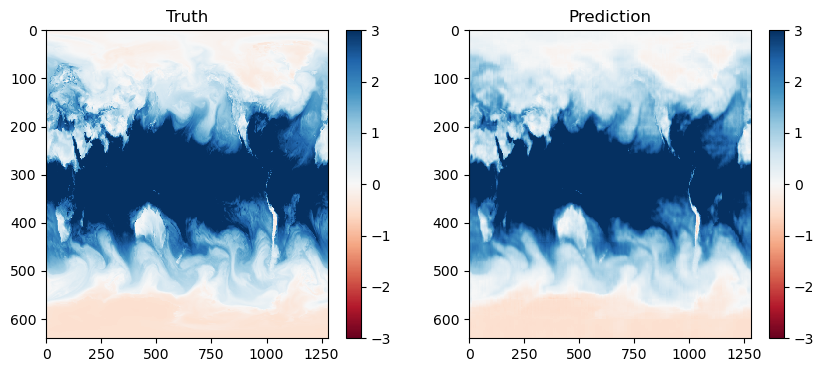

tensor([3203]) tensor([4]) tensor(0.1016, device='cuda:0', dtype=torch.float64) 0.9776477813720703


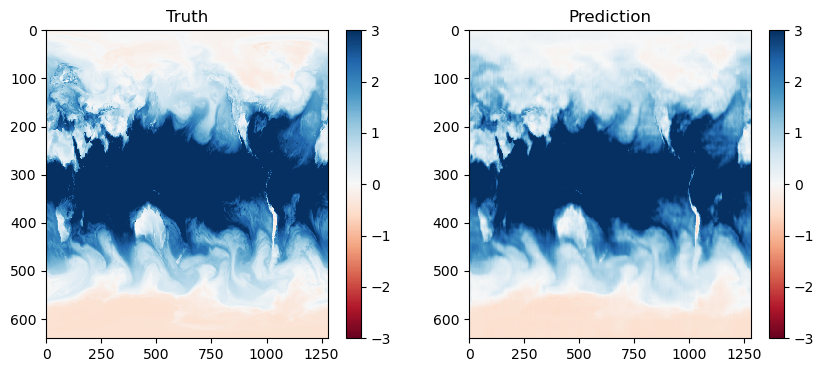

tensor([3203]) tensor([5]) tensor(0.1114, device='cuda:0', dtype=torch.float64) 0.9728429913520813


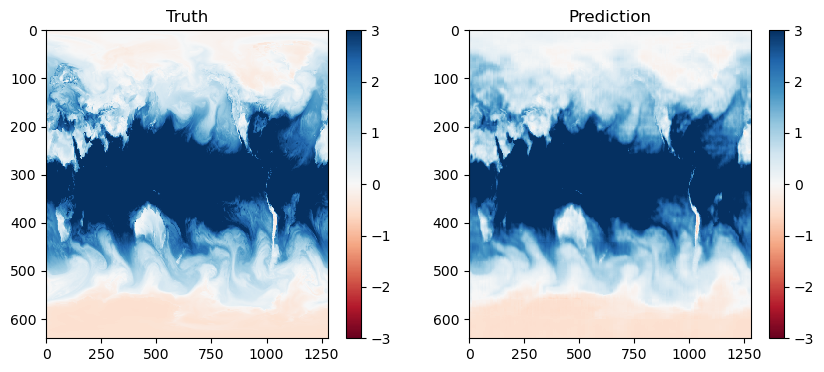

tensor([3203]) tensor([6]) tensor(0.1207, device='cuda:0', dtype=torch.float64) 0.9678516387939453


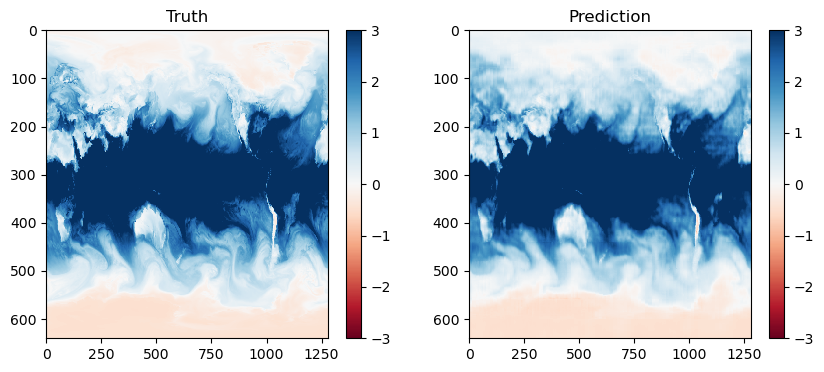

tensor([3203]) tensor([7]) tensor(0.1296, device='cuda:0', dtype=torch.float64) 0.9626834392547607


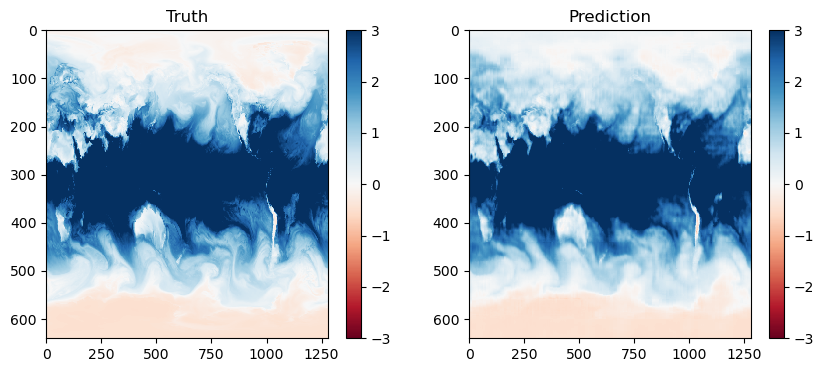

tensor([3203]) tensor([8]) tensor(0.1383, device='cuda:0', dtype=torch.float64) 0.9573248624801636


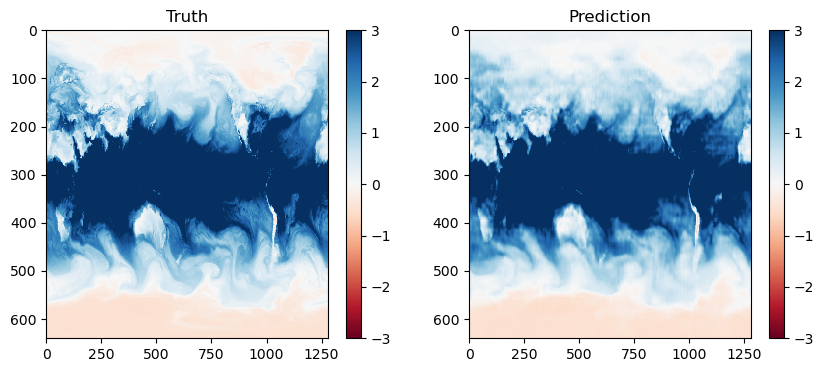

tensor([3203]) tensor([9]) tensor(0.1465, device='cuda:0', dtype=torch.float64) 0.9518272876739502


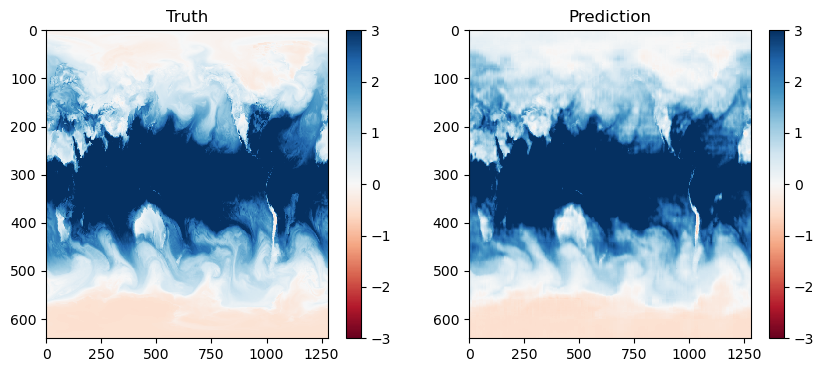

tensor([3203]) tensor([10]) tensor(0.1564, device='cuda:0', dtype=torch.float64) 0.9451107978820801


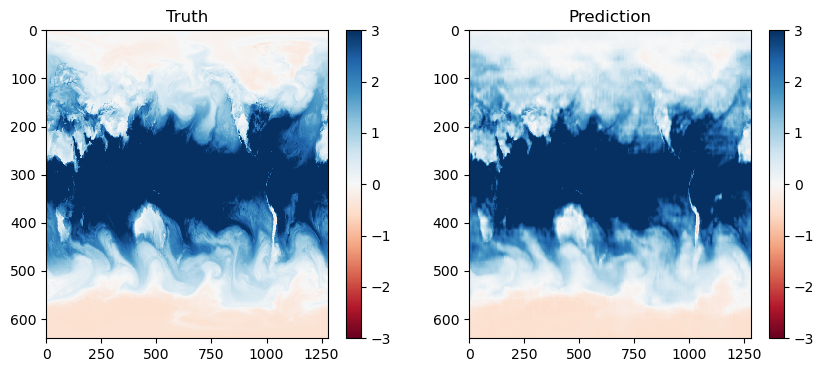

tensor([3203]) tensor([11]) tensor(0.1637, device='cuda:0', dtype=torch.float64) 0.9395850300788879


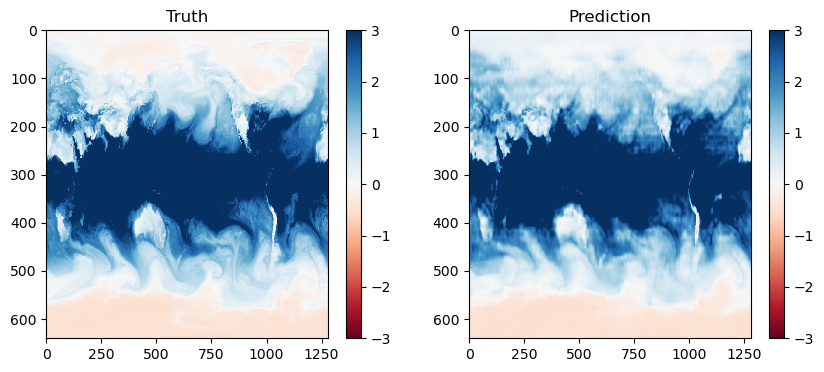

tensor([3203]) tensor([12]) tensor(0.1711, device='cuda:0', dtype=torch.float64) 0.9337775707244873


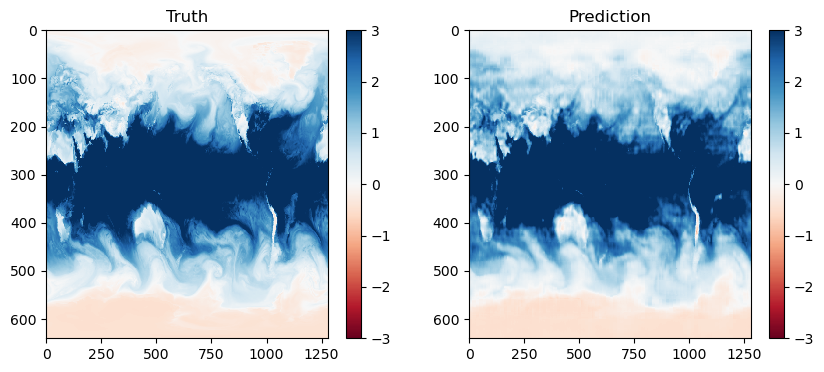

tensor([3203]) tensor([13]) tensor(0.1785, device='cuda:0', dtype=torch.float64) 0.9274651408195496


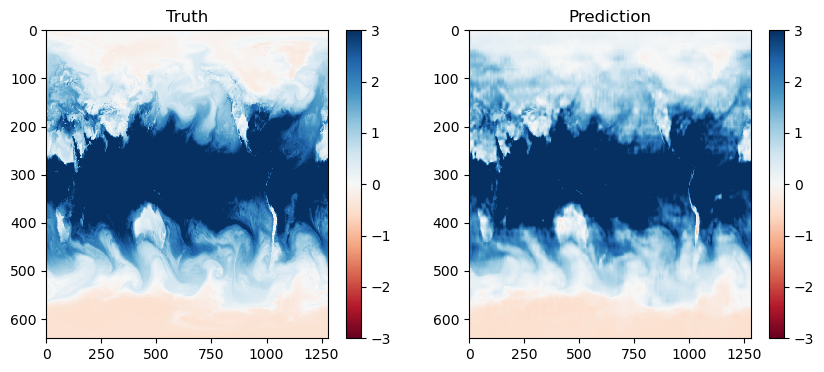

tensor([3203]) tensor([14]) tensor(0.1862, device='cuda:0', dtype=torch.float64) 0.920513391494751


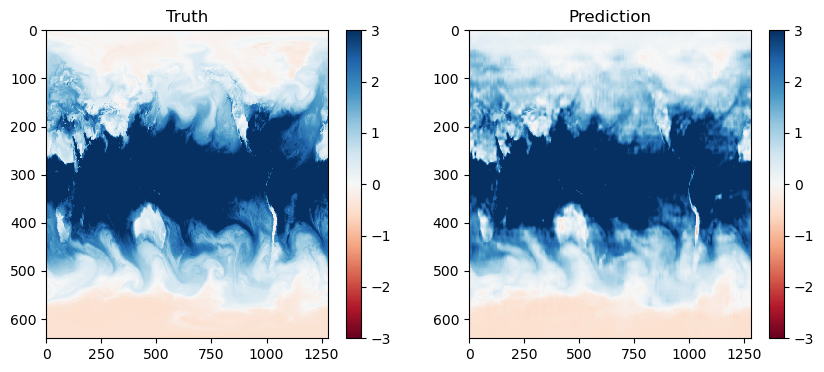

tensor([3203]) tensor([15]) tensor(0.1941, device='cuda:0', dtype=torch.float64) 0.9129579067230225


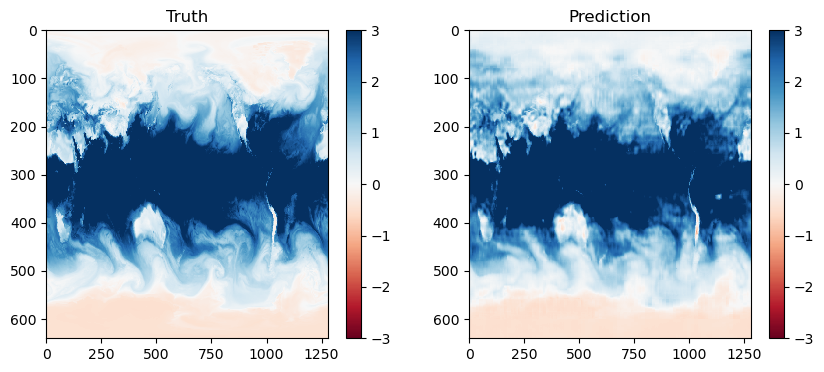

tensor([3203]) tensor([16]) tensor(0.2023, device='cuda:0', dtype=torch.float64) 0.9047436118125916


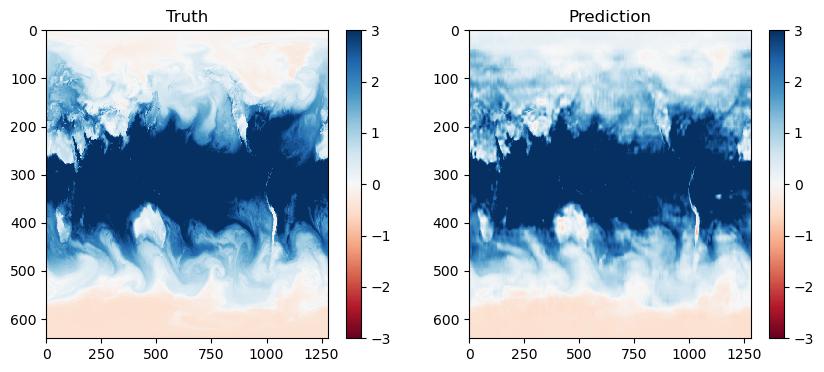

tensor([3203]) tensor([17]) tensor(0.2108, device='cuda:0', dtype=torch.float64) 0.8956674337387085


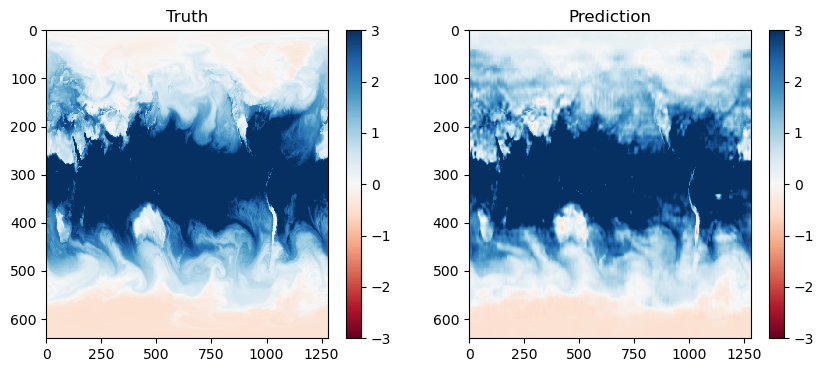

tensor([3203]) tensor([18]) tensor(0.2200, device='cuda:0', dtype=torch.float64) 0.8857370615005493


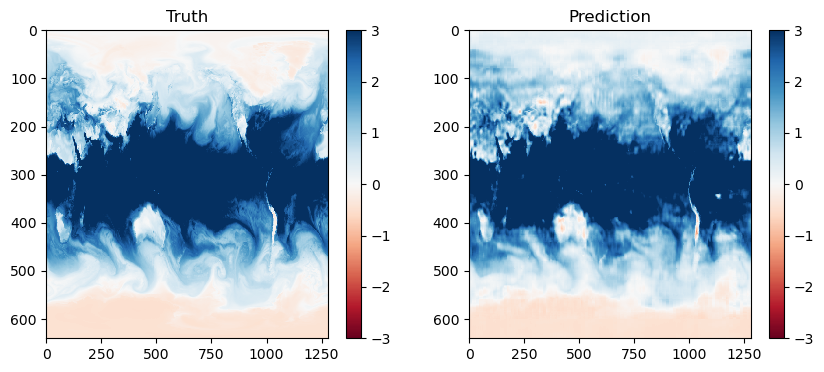

tensor([3203]) tensor([19]) tensor(0.2295, device='cuda:0', dtype=torch.float64) 0.8752120137214661


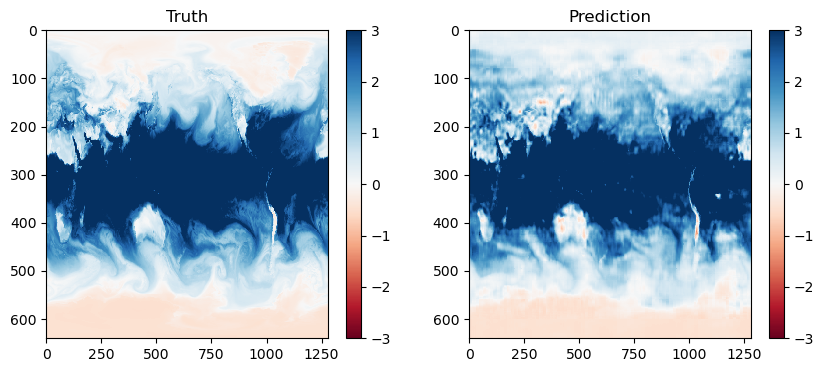

tensor([3203]) tensor([20]) tensor(0.2396, device='cuda:0', dtype=torch.float64) 0.8641048669815063


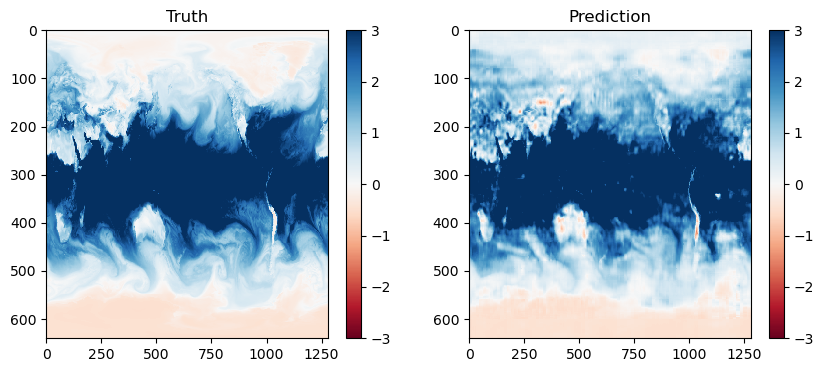

tensor([3203]) tensor([21]) tensor(0.2507, device='cuda:0', dtype=torch.float64) 0.852174699306488


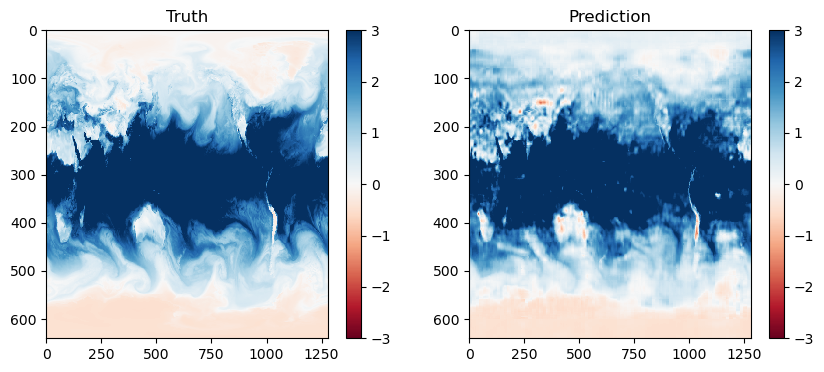

tensor([3203]) tensor([22]) tensor(0.2628, device='cuda:0', dtype=torch.float64) 0.8395626544952393


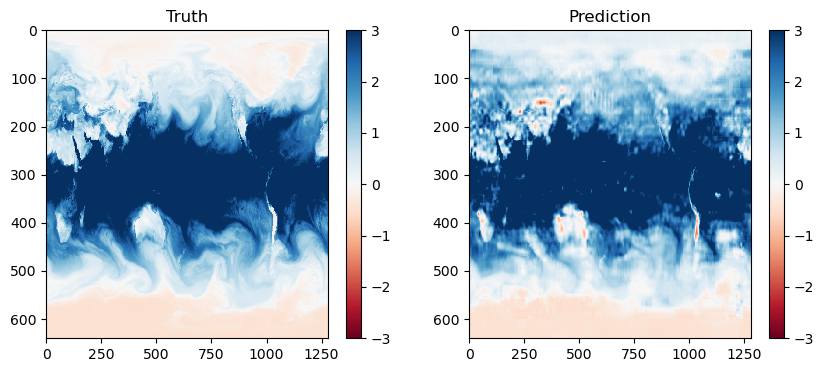

tensor([3203]) tensor([23]) tensor(0.2753, device='cuda:0', dtype=torch.float64) 0.8261114358901978


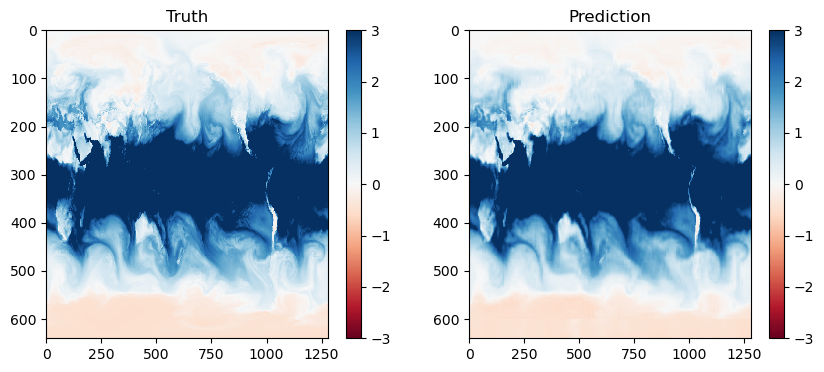

tensor([11698]) tensor([0]) tensor(0.0705, device='cuda:0', dtype=torch.float64) 0.9906434416770935


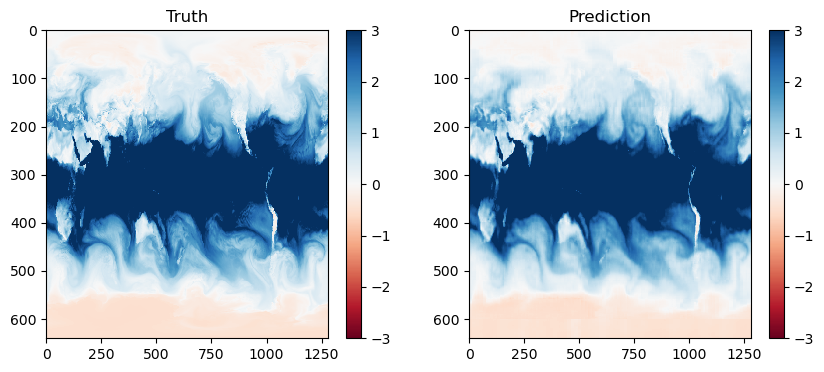

tensor([11698]) tensor([1]) tensor(0.0791, device='cuda:0', dtype=torch.float64) 0.9879811406135559


KeyboardInterrupt: 

In [61]:
%%time
model.eval()
results = defaultdict(list)
metrics_results = defaultdict(list)

history_len = 3

with torch.no_grad():
    true_arrays = []  # List to store true arrays
    pred_arrays = []  # List to store predicted arrays

    # loss_fn = torch.nn.L1Loss()
    loss_fn = VariableTotalLoss2D(conf, validation=True)
    metrics = LatWeightedMetrics(conf)

    loss = 0.0
    for batch in test_loader:
        if batch["forecast_hour"].item() == 0:
            # Initialize x and x_surf with the first time step
            x_atmo = batch["x"].squeeze(1)
            x_surf = batch["x_surf"].squeeze(1)
            x = model.concat_and_reshape(x_atmo, x_surf).to(device)

        y_atmo = batch["y"].squeeze(1)
        y_surf = batch["y_surf"].squeeze(1)
        y = model.concat_and_reshape(y_atmo, y_surf).to(device)

        # The model's output y_pred becomes the new x for the next time step
        y_pred = model(x)
        x = y_pred.detach()

        mae = loss_fn(y, y_pred)
        metrics_dict = metrics(y_pred.float(), y.float())

        for k, m in metrics_dict.items():
            metrics_results[k].append(m.item())

        loss += mae

        true_arrays.append(y[0, Dovar, :, :].to("cpu").numpy())
        pred_arrays.append(y_pred[0, Dovar, :, :].to("cpu").numpy())

        # Plotting y
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.pcolor(y[0, Dovar, :, :].to("cpu").numpy(), cmap="RdBu", vmin=-3, vmax=3)
        plt.colorbar()
        plt.gca().invert_yaxis()
        # plt.title(f'Forecast hour {data["forecast_hour"].item()}')
        plt.title("Truth")

        # Plotting y_pred
        plt.subplot(1, 2, 2)
        plt.pcolor(
            y_pred[0, Dovar, :, :].to("cpu").numpy(), cmap="RdBu", vmin=-3, vmax=3
        )
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title("Prediction")

        plt.show()

        results["forecast_hour"].append(batch["forecast_hour"].item())
        results["mae"].append(mae.item())
        results["acc"].append(ACC(y, y_pred))

        print(batch["index"], batch["forecast_hour"], mae, results["acc"][-1])

        # del y_pred, y
        # Explicitly release GPU memory
        torch.cuda.empty_cache()
        gc.collect()

        if batch["forecast_hour"].item() == 24:
            break

# Convert the lists to NumPy arrays
true_arrays = np.array(true_arrays)
pred_arrays = np.array(pred_arrays)

# Save NumPy arrays to disk
# np.save('true_arrays.npy', true_arrays)
# np.save('pred_arrays.npy', pred_arrays)

In [66]:
np.save("true_arrays.npy", true_arrays)
np.save("pred_arrays.npy", pred_arrays)

In [65]:
len(true_arrays)

26

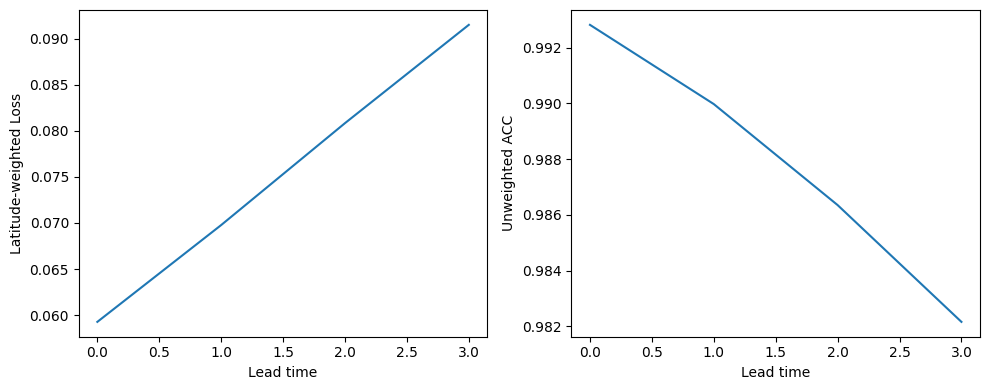

In [14]:
import matplotlib.pyplot as plt

# Assuming you have already created the 'results' DataFrame
plt.figure(figsize=(10, 4))

# Create a subplot with 1 row and 2 columns
plt.subplot(1, 2, 1)  # First column
plt.plot(results["forecast_hour"], results["mae"])
plt.xlabel("Lead time")
plt.ylabel("Latitude-weighted Loss")

plt.subplot(1, 2, 2)  # Second column
plt.plot(results["forecast_hour"], results["acc"])
plt.xlabel("Lead time")
plt.ylabel("Unweighted ACC")

plt.tight_layout()
plt.show()

In [59]:
metrics_results